In [ ]:
import psycopg2
import pandas as pd
import numpy as np
from datetime import datetime
from dateutil.relativedelta import relativedelta
import matplotlib.pyplot as plt
import seaborn as sns

db_host = "spinup-db001ec7.cluster-c9ukc6s0rmbg.us-east-1.rds.amazonaws.com"
db_name = "synthea-omop"
db_user = "introml568"
db_password = "m7bxMRtyMqPbcxyRRGML8"

try:
    conn = psycopg2.connect(
        host=db_host,
        database=db_name,
        user=db_user,
        password=db_password
    )
    print("Connected to the database!")

    person_query = "SELECT * FROM omop.person;"
    person_df = pd.read_sql_query(person_query, conn)
    person_df.to_csv("person.csv", index=False)
    print("Exported `person` table to 'person.csv'.")

    visit_query = "SELECT * FROM omop.visit_occurrence;"
    visit_df = pd.read_sql_query(visit_query, conn)
    visit_df.to_csv("visit_occurrence.csv", index=False)
    print("Exported `visit_occurrence` table to 'visit_occurrence.csv'.")

    measurement_query = "SELECT * FROM omop.measurement;"
    measurement_df = pd.read_sql_query(measurement_query, conn)
    measurement_df.to_csv("measurement.csv", index=False)
    print("Exported `measurement` table to 'measurement.csv'.")

    concept_query = "SELECT * FROM omop.concept;"
    concept_df = pd.read_sql_query(concept_query, conn)
    concept_df.to_csv("concept.csv", index=False)
    print("Exported `concept` table to 'concept.csv'.")

    condition_query = "SELECT * FROM omop.condition_occurrence;"
    condition_df = pd.read_sql_query(condition_query, conn)
    condition_df.to_csv("condition_occurrence.csv", index=False)
    print("Exported `condition_occurrence` table to 'condition_occurrence.csv'.")

    death_query = "SELECT * FROM omop.death;"
    death_df = pd.read_sql_query(death_query, conn)
    death_df.to_csv("death.csv", index=False)
    print("Exported `death` table to 'death.csv'.")

except Exception as e:
    print(f"Error: {e}")

finally:
    if conn:
        conn.close()
        print("Connection closed.")


Connected to the database!


/var/folders/pf/rj45l2zj22jcfn733_v399pw0000gn/T/ipykernel_43331/53311144.py:22: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  person_df = pd.read_sql_query(person_query, conn)


Exported `person` table to 'person.csv'.


/var/folders/pf/rj45l2zj22jcfn733_v399pw0000gn/T/ipykernel_43331/53311144.py:28: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  visit_df = pd.read_sql_query(visit_query, conn)


Exported `visit_occurrence` table to 'visit_occurrence.csv'.


/var/folders/pf/rj45l2zj22jcfn733_v399pw0000gn/T/ipykernel_43331/53311144.py:34: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  measurement_df = pd.read_sql_query(measurement_query, conn)


Exported `measurement` table to 'measurement.csv'.


/var/folders/pf/rj45l2zj22jcfn733_v399pw0000gn/T/ipykernel_43331/53311144.py:40: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  concept_df = pd.read_sql_query(concept_query, conn)


Exported `concept` table to 'concept.csv'.


/var/folders/pf/rj45l2zj22jcfn733_v399pw0000gn/T/ipykernel_43331/53311144.py:46: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  condition_df = pd.read_sql_query(condition_query, conn)


Exported `condition_occurrence` table to 'condition_occurrence.csv'.
Exported `death` table to 'death.csv'.
Connection closed.


/var/folders/pf/rj45l2zj22jcfn733_v399pw0000gn/T/ipykernel_43331/53311144.py:52: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  death_df = pd.read_sql_query(death_query, conn)


In [ ]:
def person_age(birth_datetime):
    today = datetime.today()
    return today.year - birth_datetime.year - ((today.month, today.day) < (birth_datetime.month, birth_datetime.day))

person = pd.read_csv("person.csv")
visit_occurrence = pd.read_csv("visit_occurrence.csv")
measurement = pd.read_csv("measurement.csv")
condition_occurrence = pd.read_csv("condition_occurrence.csv")
concept = pd.read_csv("concept.csv")
death = pd.read_csv("death.csv")

/var/folders/pf/rj45l2zj22jcfn733_v399pw0000gn/T/ipykernel_43331/2481801949.py:16: DtypeWarning: Columns (5,6,9) have mixed types. Specify dtype option on import or set low_memory=False.
  concept = pd.read_csv("concept.csv")


In [ ]:
person["birth_datetime"] = pd.to_datetime(person["birth_datetime"])
person["current_age"] = person["birth_datetime"].apply(person_age)
person = person[~person["person_id"].isin(death["person_id"])]
visit_occurrence["visit_start_datetime"] = pd.to_datetime(visit_occurrence["visit_start_datetime"])
visit_occurrence["visit_end_datetime"] = pd.to_datetime(visit_occurrence["visit_end_datetime"])
person_visit_merged = visit_occurrence.merge(person, on="person_id", how="inner")

person_visit_merged = person_visit_merged.sort_values(by=["person_id", "visit_start_datetime"])
person_visit_merged["visit_sequence"] = person_visit_merged.groupby("person_id").cumcount() + 1
person_visit_merged["visit_length"] = (person_visit_merged["visit_end_datetime"] - person_visit_merged["visit_start_datetime"]).dt.days + 1
person_visit_merged["age_at_visit"] = person_visit_merged.apply(
    lambda x: relativedelta(x["visit_start_datetime"], x["birth_datetime"]).years, axis=1
)
cohort_data = person_visit_merged[
    (person_visit_merged["age_at_visit"].between(52, 56)) &
    (person_visit_merged["visit_sequence"].between(1, 37))
]
df_conditions = condition_occurrence.merge(concept, left_on="condition_concept_id", right_on="concept_id", how="inner")
df_conditions['hypertension'] = df_conditions['concept_name'].str.contains('hypertension', case=False, na=False).astype(int)
df_conditions['diabetes'] = df_conditions['concept_name'].str.contains('diabetes', case=False, na=False).astype(int)
conditions = df_conditions.groupby("person_id").agg(
    has_hypertension=("hypertension", "max"),
    has_diabetes=("diabetes", "max")
).reset_index()
cohort_data = cohort_data.merge(conditions, on="person_id", how="left")
cohort_data["has_hypertension"].fillna(0, inplace=True)
cohort_data["has_diabetes"].fillna(0, inplace=True)
measurement["measurement_datetime"] = pd.to_datetime(measurement["measurement_datetime"])
measurement_concept_map = dict(zip(concept["concept_id"], concept["concept_name"]))
measurement["biomarker_name"] = measurement["measurement_concept_id"].map(measurement_concept_map)
measurement_pivot = measurement.pivot_table(
    index="visit_occurrence_id",
    columns="biomarker_name",
    values="value_as_number",
    aggfunc="first"
).reset_index()
measurement_pivot.columns = ["visit_occurrence_id"] + [f"measurement_{i+1} ({col})" for i, col in enumerate(measurement_pivot.columns[1:])]
cohort_data = cohort_data.merge(measurement_pivot, on="visit_occurrence_id", how="left")
systolic_bp_column = [col for col in cohort_data.columns if "Systolic blood pressure" in col]
if systolic_bp_column:
    systolic_bp_column = systolic_bp_column[0]
    high_bp_filter = cohort_data["visit_sequence"].between(3, 17) & cohort_data[systolic_bp_column].gt(130, fill_value=0)
    cohort_data = cohort_data[~high_bp_filter]
measurement_columns = [col for col in cohort_data.columns if col.startswith("measurement_")]
cohort_data = cohort_data[cohort_data[measurement_columns].notna().any(axis=1)]

concept_map = dict(zip(concept["concept_id"], concept["concept_name"]))
cohort_data["gender"] = cohort_data["gender_concept_id"].map(concept_map)
cohort_data["race"] = cohort_data["race_concept_id"].map(concept_map)
cohort_data["ethnicity"] = cohort_data["ethnicity_concept_id"].map(concept_map)
cohort_data = cohort_data.drop(columns=["gender_concept_id", "race_concept_id", "ethnicity_concept_id"])
cohort_data.rename(columns={"visit_start_datetime": "visit_date"}, inplace=True)
final_columns = [
    "visit_date", "person_id", "gender", "current_age", "age_at_visit",
    "race", "ethnicity", "visit_length", "has_hypertension", "has_diabetes"
] + measurement_columns
cohort_data = cohort_data[final_columns]
cohort_data[measurement_columns] = cohort_data[measurement_columns].fillna("NA")
cohort_data.to_csv("dat.csv", index=False)
print("Cohort data saved as 'dat.csv' with converted concept values.")

### section 2

/var/folders/pf/rj45l2zj22jcfn733_v399pw0000gn/T/ipykernel_55321/445191941.py:39: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(
/var/folders/pf/rj45l2zj22jcfn733_v399pw0000gn/T/ipykernel_55321/445191941.py:51: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(
/var/folders/pf/rj45l2zj22jcfn733_v399pw0000gn/T/ipykernel_55321/445191941.py:51: UserWarning: The palette list has more values (8) than needed (4), which may not be intended.
  sns.barplot(


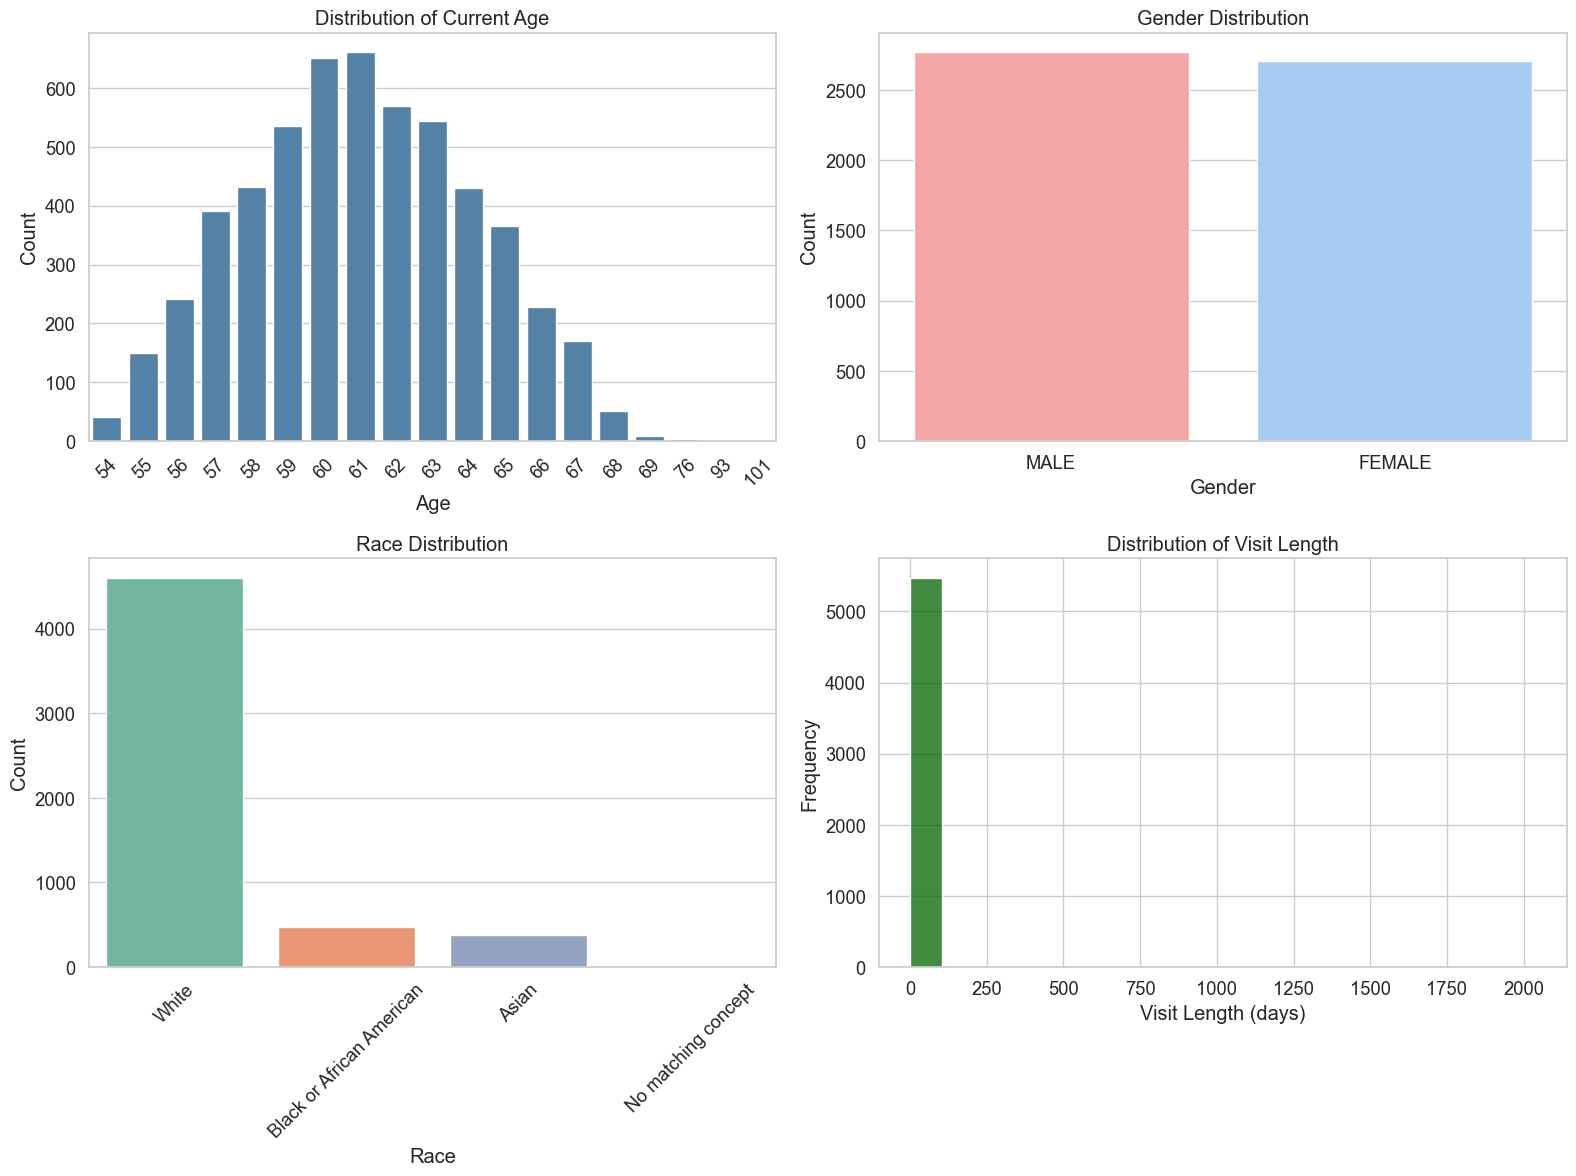

In [1]:
import psycopg2
import pandas as pd
import numpy as np
from datetime import datetime
from dateutil.relativedelta import relativedelta
import matplotlib.pyplot as plt
import seaborn as sns

# Load dataset
cohort_data = pd.read_csv("dat.csv")

# Set seaborn style and font scale
sns.set(style="whitegrid", font_scale=1.2)

# Define custom palettes
custom_bar_color = "steelblue"  # Custom color for bar charts
gender_palette = ["#FF9999", "#99CCFF"]  # Custom pastel colors for gender
race_palette = sns.color_palette("Set2")  # Muted color palette for race
visit_length_color = "darkgreen"  # Custom color for the histogram

# Create subplots
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# 1. Distribution of Current Age
age_counts = cohort_data["current_age"].value_counts().sort_index()
sns.barplot(
    x=age_counts.index,
    y=age_counts.values,
    ax=axes[0, 0],
    color=custom_bar_color
)
axes[0, 0].set_title("Distribution of Current Age")
axes[0, 0].set_xlabel("Age")
axes[0, 0].set_ylabel("Count")
axes[0, 0].tick_params(axis="x", rotation=45)

# 2. Gender Distribution
gender_counts = cohort_data["gender"].value_counts()
sns.barplot(
    x=gender_counts.index,
    y=gender_counts.values,
    ax=axes[0, 1],
    palette=gender_palette
)
axes[0, 1].set_title("Gender Distribution")
axes[0, 1].set_xlabel("Gender")
axes[0, 1].set_ylabel("Count")

# 3. Race Distribution
race_counts = cohort_data["race"].value_counts()
sns.barplot(
    x=race_counts.index,
    y=race_counts.values,
    ax=axes[1, 0],
    palette=race_palette
)
axes[1, 0].set_title("Race Distribution")
axes[1, 0].set_xlabel("Race")
axes[1, 0].set_ylabel("Count")
axes[1, 0].tick_params(axis="x", rotation=45)

# 4. Distribution of Visit Length
sns.histplot(
    cohort_data["visit_length"],
    bins=20,
    kde=False,
    ax=axes[1, 1],
    color=visit_length_color
)
axes[1, 1].set_title("Distribution of Visit Length")
axes[1, 1].set_xlabel("Visit Length (days)")
axes[1, 1].set_ylabel("Frequency")

# Adjust layout and display the plots
plt.tight_layout()
plt.show()


In [2]:
def person_age(birth_datetime):
    today = datetime.today()
    return today.year - birth_datetime.year - ((today.month, today.day) < (birth_datetime.month, birth_datetime.day))
person = pd.read_csv("person.csv")
visit_occurrence = pd.read_csv("visit_occurrence.csv")
measurement = pd.read_csv("measurement.csv")
condition_occurrence = pd.read_csv("condition_occurrence.csv")
concept = pd.read_csv("concept.csv")
death = pd.read_csv("death.csv")
person["birth_datetime"] = pd.to_datetime(person["birth_datetime"])
person["current_age"] = person["birth_datetime"].apply(person_age)
person = person[~person["person_id"].isin(death["person_id"])]
visit_occurrence["visit_start_datetime"] = pd.to_datetime(visit_occurrence["visit_start_datetime"])
visit_occurrence["visit_end_datetime"] = pd.to_datetime(visit_occurrence["visit_end_datetime"])
person_visit_merged = visit_occurrence.merge(person, on="person_id", how="inner")
person_visit_merged = person_visit_merged.sort_values(by=["person_id", "visit_start_datetime"])
person_visit_merged["visit_sequence"] = person_visit_merged.groupby("person_id").cumcount() + 1
person_visit_merged["visit_length"] = (person_visit_merged["visit_end_datetime"] - person_visit_merged["visit_start_datetime"]).dt.days + 1
person_visit_merged["age_at_visit"] = person_visit_merged.apply(
    lambda x: relativedelta(x["visit_start_datetime"], x["birth_datetime"]).years, axis=1
)
cohort_data = person_visit_merged[
    (person_visit_merged["age_at_visit"].between(52, 56)) &
    (person_visit_merged["visit_sequence"].between(1, 37))
]
df_conditions = condition_occurrence.merge(concept, left_on="condition_concept_id", right_on="concept_id", how="inner")
df_conditions['hypertension'] = df_conditions['concept_name'].str.contains('hypertension', case=False, na=False).astype(int)
df_conditions['diabetes'] = df_conditions['concept_name'].str.contains('diabetes', case=False, na=False).astype(int)
conditions = df_conditions.groupby("person_id").agg(
    has_hypertension=("hypertension", "max"),
    has_diabetes=("diabetes", "max")
).reset_index()
cohort_data = cohort_data.merge(conditions, on="person_id", how="left")
cohort_data["has_hypertension"].fillna(0, inplace=True)
cohort_data["has_diabetes"].fillna(0, inplace=True)
measurement["measurement_datetime"] = pd.to_datetime(measurement["measurement_datetime"])
measurement_concept_map = dict(zip(concept["concept_id"], concept["concept_name"]))
measurement["biomarker_name"] = measurement["measurement_concept_id"].map(measurement_concept_map)
measurement_pivot = measurement.pivot_table(
    index="visit_occurrence_id",
    columns="biomarker_name",
    values="value_as_number",
    aggfunc="first"
).reset_index()
measurement_pivot.columns = ["visit_occurrence_id"] + [f"measurement_{i+1} ({col})" for i, col in enumerate(measurement_pivot.columns[1:])]
cohort_data = cohort_data.merge(measurement_pivot, on="visit_occurrence_id", how="left")
systolic_bp_column = [col for col in cohort_data.columns if "Systolic blood pressure" in col]
if systolic_bp_column:
    systolic_bp_column = systolic_bp_column[0]
    high_bp_filter = cohort_data["visit_sequence"].between(3, 17) & cohort_data[systolic_bp_column].gt(130, fill_value=0)
    cohort_data = cohort_data[~high_bp_filter]
measurement_columns = [col for col in cohort_data.columns if col.startswith("measurement_")]
cohort_data = cohort_data[cohort_data[measurement_columns].notna().any(axis=1)]
cohort_data.rename(columns={"visit_start_datetime": "visit_date"}, inplace=True)
cohort_data[measurement_columns] = cohort_data[measurement_columns].fillna("NA")
visit_occurrence["visit_date"] = visit_occurrence["visit_start_datetime"].dt.date
cohort_data["visit_date"] = pd.to_datetime(cohort_data["visit_date"]).dt.date
cohort_data = cohort_data.merge(
    visit_occurrence[["person_id", "visit_date", "visit_concept_id", "discharged_to_concept_id"]],
    on=["person_id", "visit_date"],
    how="left"
)
visit_concept_map = dict(zip(concept["concept_id"], concept["concept_name"]))
cohort_data["visit_concept"] = cohort_data["visit_concept_id_x"].map(visit_concept_map)
cohort_data["discharge_location"] = cohort_data["discharged_to_concept_id_x"].map(visit_concept_map)
cohort_data["visit_concept"].fillna("Unknown", inplace=True)
cohort_data["discharge_location"].fillna("Unknown", inplace=True)
person_visit_merged["visit_sequence"] = person_visit_merged.groupby("person_id").cumcount() + 1
person_visit_merged["visit_date"] = person_visit_merged["visit_start_datetime"].dt.date
cohort_data["visit_date"] = pd.to_datetime(cohort_data["visit_date"]).dt.date
cohort_data = cohort_data.merge(
    person_visit_merged[["person_id", "visit_date", "visit_sequence"]],
    on=["person_id", "visit_date"],
    how="left"
)

/var/folders/pf/rj45l2zj22jcfn733_v399pw0000gn/T/ipykernel_55321/302258771.py:8: DtypeWarning: Columns (5,6,9) have mixed types. Specify dtype option on import or set low_memory=False.
  concept = pd.read_csv("concept.csv")
/var/folders/pf/rj45l2zj22jcfn733_v399pw0000gn/T/ipykernel_55321/302258771.py:64: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  cohort_data["visit_concept"] = cohort_data["visit_concept_id_x"].map(visit_concept_map)
/var/folders/pf/rj45l2zj22jcfn733_v399pw0000gn/T/ipykernel_55321/302258771.py:65: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame

/var/folders/pf/rj45l2zj22jcfn733_v399pw0000gn/T/ipykernel_55321/1742050245.py:15: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(
/var/folders/pf/rj45l2zj22jcfn733_v399pw0000gn/T/ipykernel_55321/1742050245.py:15: UserWarning: 
The palette list has fewer values (6) than needed (37) and will cycle, which may produce an uninterpretable plot.
  sns.boxplot(
/var/folders/pf/rj45l2zj22jcfn733_v399pw0000gn/T/ipykernel_55321/1742050245.py:26: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(
/var/folders/pf/rj45l2zj22jcfn733_v399pw0000gn/T/ipykernel_55321/1742050245.py:26: UserWarning: The palette list has more values (6) than needed (2), which may not be intended.
  sns.boxplot(
/var/folders/pf/rj45

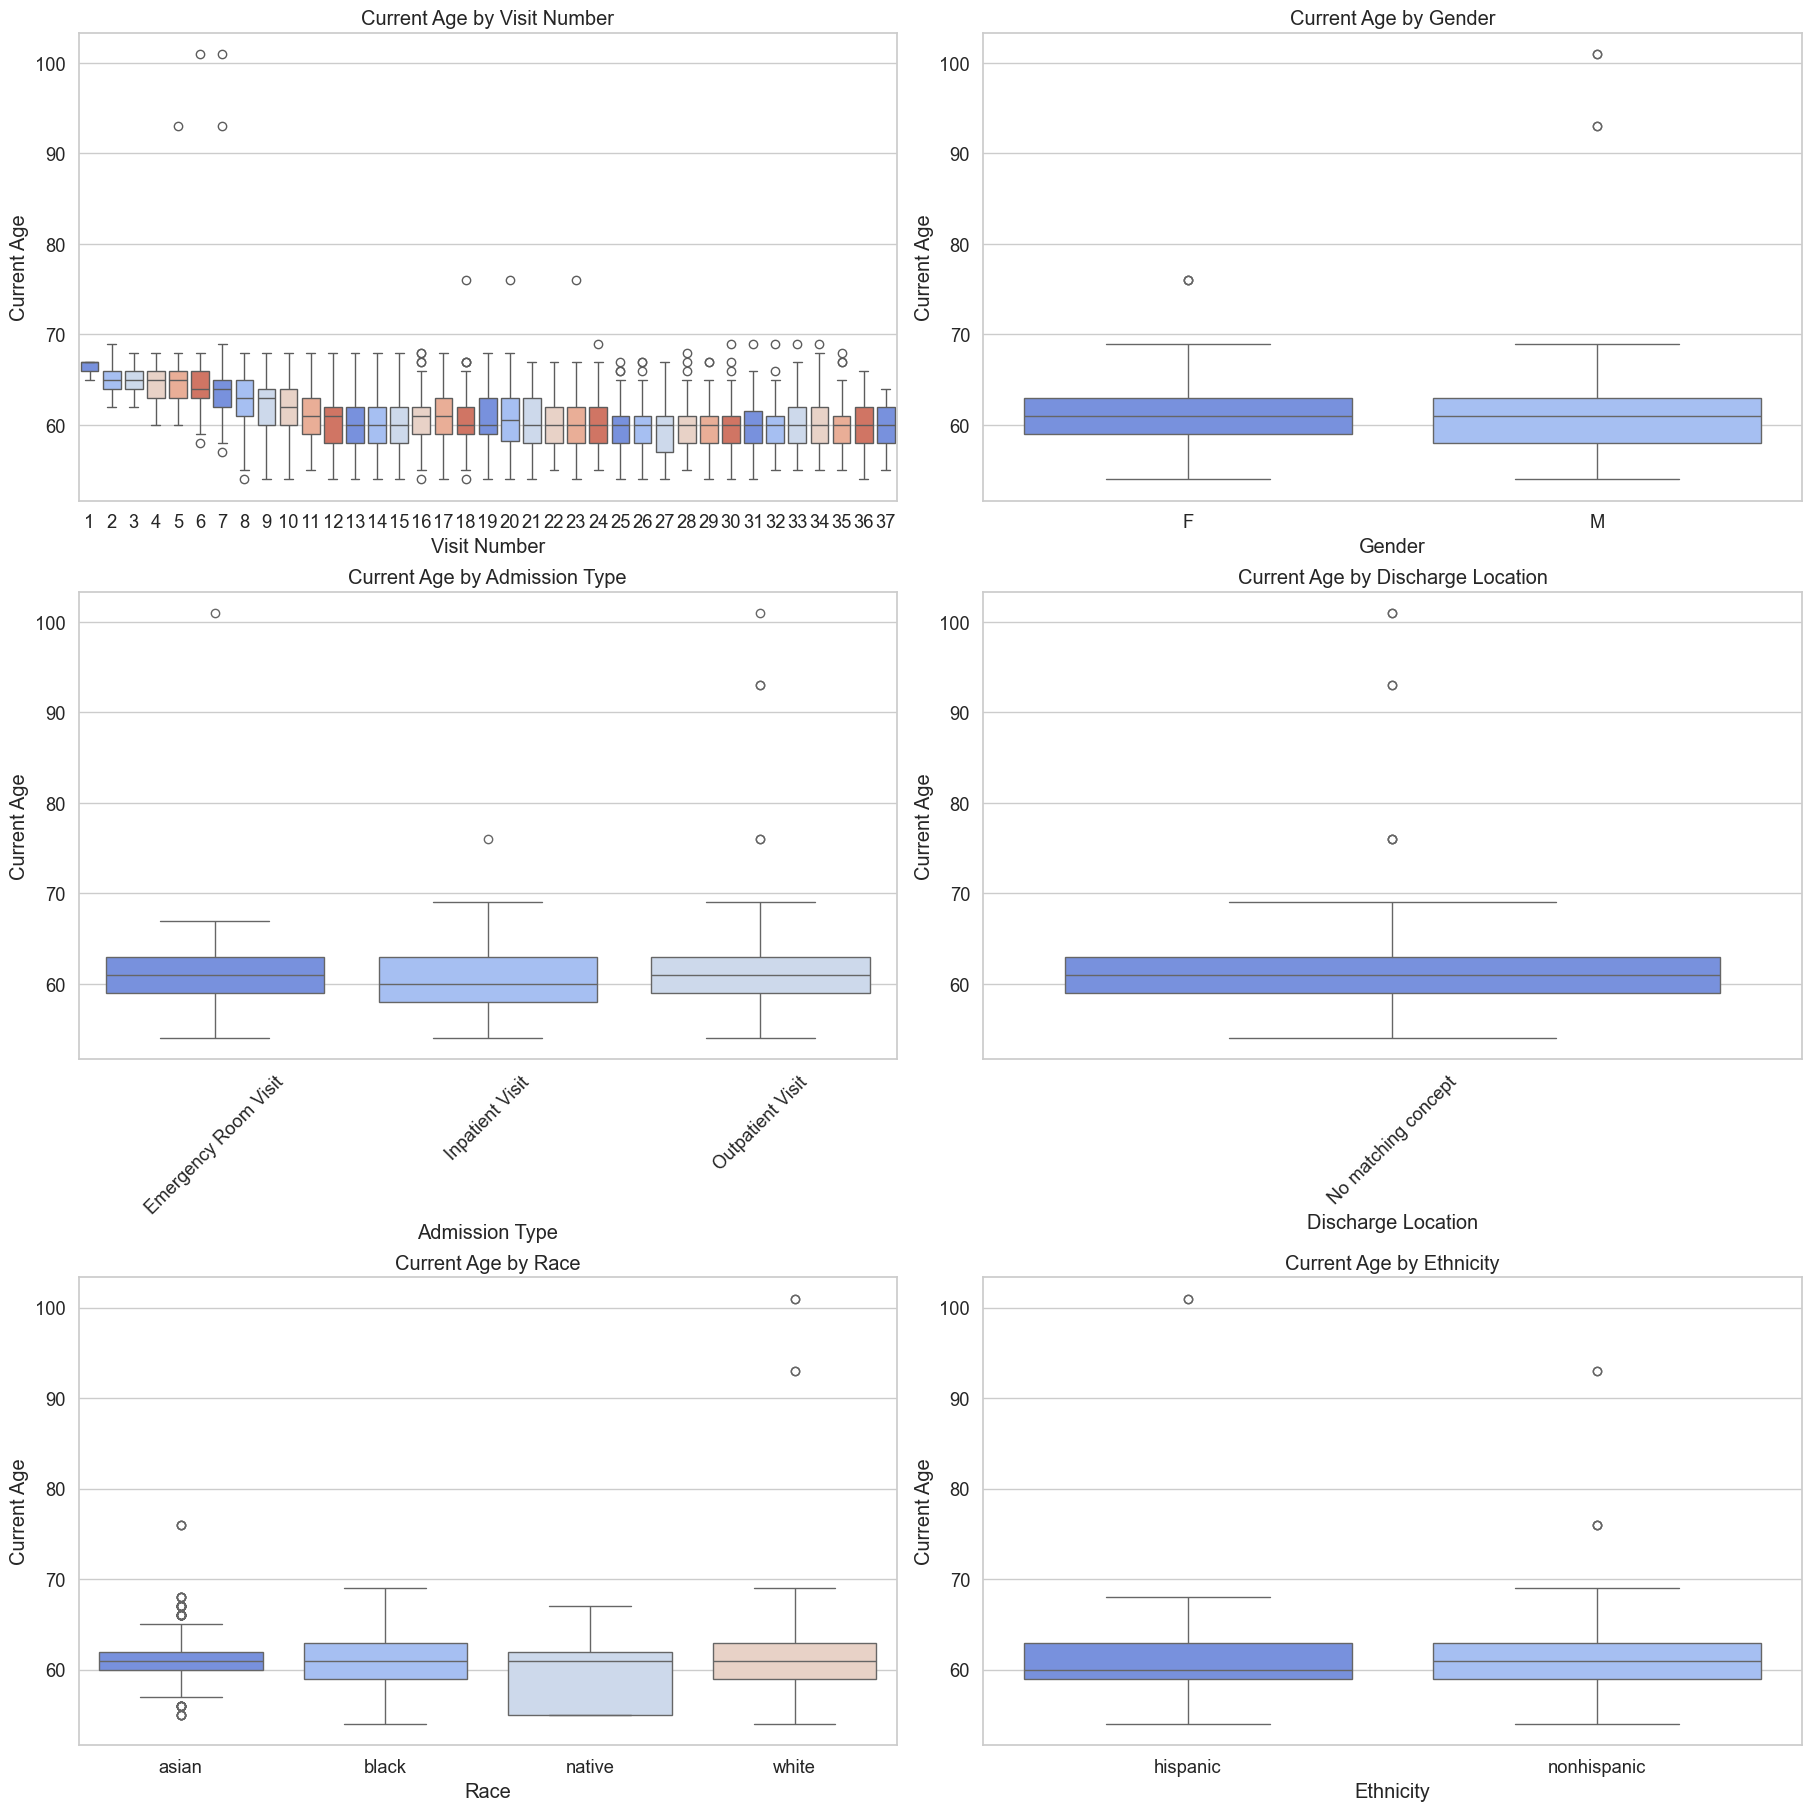

In [5]:
import seaborn as sns
import matplotlib.pyplot as plt

custom_palette = sns.color_palette("coolwarm")

visit_sequence_order = sorted(cohort_data["visit_sequence_x"].dropna().unique())
gender_order = sorted(cohort_data["gender_source_value"].dropna().unique())
visit_concept_order = sorted(cohort_data["visit_concept"].dropna().unique())
discharge_location_order = sorted(cohort_data["discharge_location"].dropna().unique())
race_order = sorted(cohort_data["race_source_value"].dropna().unique())
ethnicity_order = sorted(cohort_data["ethnicity_source_value"].dropna().unique())

fig, axes = plt.subplots(3, 2, figsize=(18, 18), constrained_layout=True)

sns.boxplot(
    x=cohort_data["visit_sequence_x"],
    y=cohort_data["current_age"],
    ax=axes[0, 0],
    palette=custom_palette,
    order=visit_sequence_order
)
axes[0, 0].set_title("Current Age by Visit Number")
axes[0, 0].set_xlabel("Visit Number")
axes[0, 0].set_ylabel("Current Age")

sns.boxplot(
    x=cohort_data["gender_source_value"],
    y=cohort_data["current_age"],
    ax=axes[0, 1],
    palette=custom_palette,
    order=gender_order
)
axes[0, 1].set_title("Current Age by Gender")
axes[0, 1].set_xlabel("Gender")
axes[0, 1].set_ylabel("Current Age")

sns.boxplot(
    x=cohort_data["visit_concept"],
    y=cohort_data["current_age"],
    ax=axes[1, 0],
    palette=custom_palette,
    order=visit_concept_order
)
axes[1, 0].set_title("Current Age by Admission Type")
axes[1, 0].set_xlabel("Admission Type")
axes[1, 0].set_ylabel("Current Age")
axes[1, 0].tick_params(axis='x', rotation=45)

sns.boxplot(
    x=cohort_data["discharge_location"],
    y=cohort_data["current_age"],
    ax=axes[1, 1],
    palette=custom_palette,
    order=discharge_location_order
)
axes[1, 1].set_title("Current Age by Discharge Location")
axes[1, 1].set_xlabel("Discharge Location")
axes[1, 1].set_ylabel("Current Age")
axes[1, 1].tick_params(axis='x', rotation=45)

sns.boxplot(
    x=cohort_data["race_source_value"],
    y=cohort_data["current_age"],
    ax=axes[2, 0],
    palette=custom_palette,
    order=race_order
)
axes[2, 0].set_title("Current Age by Race")
axes[2, 0].set_xlabel("Race")
axes[2, 0].set_ylabel("Current Age")

sns.boxplot(
    x=cohort_data["ethnicity_source_value"],
    y=cohort_data["current_age"],
    ax=axes[2, 1],
    palette=custom_palette,
    order=ethnicity_order
)
axes[2, 1].set_title("Current Age by Ethnicity")
axes[2, 1].set_xlabel("Ethnicity")
axes[2, 1].set_ylabel("Current Age")

plt.show()
